# Statistical hypothesis testing for plastic detection

In this notebook, we will design a workflow for plastic detection using statistical hypothesis testing. Our dataset is composed of 5 labelled multispectral images (thera are 6 images but one of them has too many clouds so we can't detect plastic). We will make assumptions about our dataset

In [70]:
# imports

import numpy as np
import spectral
from PIL import Image
import os
import matplotlib.pyplot as plt
import utils
import tifffile
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from os import listdir
from scipy.spatial import distance
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import jaccard_score

In [2]:
data_dir = './data/'
img_name = listdir(data_dir)
print(img_name)

# il faut qu'on enregistre cette variable, elle permet de bien labelliser la terre et la mer dans le kmeans de segmentation
spectral_sign = {'water': [0.09084029, 0.10384066, 0.13632251, 0.16474463, 0.20498492,
       0.27273035, 0.29075953, 0.3045134 , 0.30009118, 0.29606405,
       0.28577173, 0.23582576], 'ground':[0.04694605, 0.03796409, 0.03244987, 0.02011696, 0.02140728,
       0.01972304, 0.02036767, 0.01891139, 0.02002294, 0.02978452,
       0.02321231, 0.02031878]}

['2019_04_18_M', '2019_05_03_M', '2019_05_08_M', '2019_05_18_M', '2019_05_28_M', '2019_06_07_M', 'label', 'Mytilene']


# Get dataset for statistical hypothesis testing

In [3]:
# NE PAS EXECUTER

# def get_data_hyp(data_dir, bands,spectral_sign):
#     img_name = listdir(data_dir)
#     data_per_band = [[] for i in range(len(bands))]
#     label_im_l = []
#     for e in [img_name[0]] :
#         if e!='label' and e!='Mytilene':
#             data_im, label_im = utils.get_batch(bands, e, all = False)
#             m,n = label_im.shape
#             label_im_l.append(label_im)
#             arrays_flat = np.array([data_im[:,:,i].flatten() for i in range(len(bands))])
#             X = (np.transpose(arrays_flat))
            
#             # kmeans pour segmenter l'eau et la terre
#             kmeans = KMeans(n_clusters=2,  init='k-means++', n_init=10, max_iter=1000)
#             kmeans.fit(X)
#             labels=kmeans.labels_
#             img_labels = labels.reshape(m,n)
#             clust = kmeans.cluster_centers_
#             ground_label = 100
#             d1 = distance.euclidean(clust[0], spectral_sign['ground'])
#             d2 = distance.euclidean(clust[1], spectral_sign['ground'])
            
#             if d1<d2:
#                 ground_label = 1
#             else : 
#                 ground_label = 0
                
#             # on remplace la terre par NaN et pn ajoute ces pixels à la liste de bandes correspondantes
#             for i in range(len(bands)):
#                 ori_array = data_im[:,:,i]
#                 ori_array[img_labels == ground_label] = np.NaN
#                 data_per_band[i] = data_per_band[i] + list(ori_array.flatten())
#             # permet de vérifier qu'on a bien que la mer
#             plt.figure()    
#             plt.imshow(ori_array)
#     return data_per_band, label_im_l

In this dataset, we removed the land thanks to a very simple kmeans clustering algorithm.
We get 2 lists. One list of the pixels for each band of the 6 images (data_per_band), the other one for the labels per image. The bands we've chosen to study are RGB+NIR, regarding the embarkability capabilities of our CubeSat.

In [4]:
# get une liste data_per_band des données de chaque image. Dans chaque donnée data_per_band[i] on a une liste des pixels par bandes
# label_im_l représente les labels pour chaque image considérée

def get_data_hyp(data_dir, bands,spectral_sign):
    img_name = listdir(data_dir)
    data_per_band = [[] for i in range(len(img_name))]
    label_im_l = []
    i=0
    for e in img_name :
        if e!='label' and e!='Mytilene':
            print('image : ', e)
            data_im, label_im = utils.get_batch(bands, e, all = False)
            m,n = label_im.shape
            label_im_l.append(label_im)
            arrays_flat = np.array([data_im[:,:,i].flatten() for i in range(len(bands))])
            X = (np.transpose(arrays_flat))
            
            # kmeans pour segmenter l'eau et la terre
            kmeans = KMeans(n_clusters=2,  init='k-means++', n_init=10, max_iter=1000)
            kmeans.fit(X)
            labels=kmeans.labels_
            img_labels = labels.reshape(m,n)
            clust = kmeans.cluster_centers_
            ground_label = 100
            d1 = distance.euclidean(clust[0], spectral_sign['ground'])
            d2 = distance.euclidean(clust[1], spectral_sign['ground'])
            
            if d1<d2:
                ground_label = 1
            else : 
                ground_label = 0
                
            # on remplace la terre par NaN et pn ajoute ces pixels à la liste de bandes correspondantes
            for j in range(len(bands)):
                ori_array = data_im[:,:,j]
                ori_array[img_labels == ground_label] = np.NaN
                data_per_band[i].append(ori_array.flatten())
            # permet de vérifier qu'on a bien que la mer
            plt.figure()    
            plt.imshow(ori_array)
            i+=1
            plt.show()
    return data_per_band, label_im_l

Plot the data without the land.

['2019_04_18_M', '2019_05_03_M', '2019_05_08_M', '2019_05_18_M', '2019_05_28_M', '2019_06_07_M', 'label', 'Mytilene']
image :  2019_04_18_M


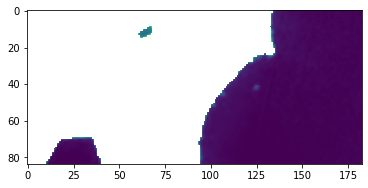

image :  2019_05_03_M


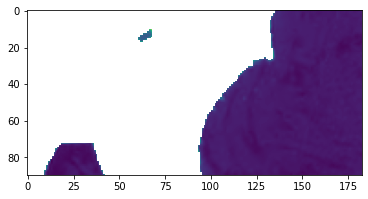

image :  2019_05_08_M


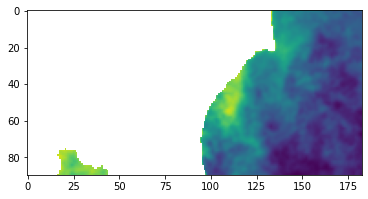

image :  2019_05_18_M


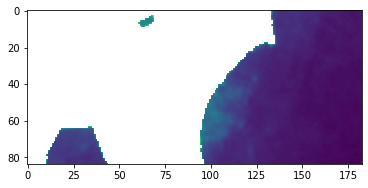

image :  2019_05_28_M


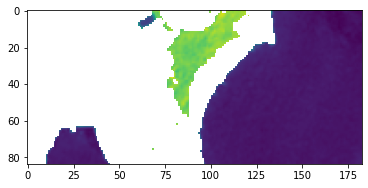

image :  2019_06_07_M


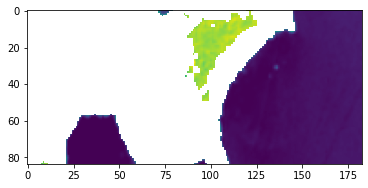

In [5]:
bands = ['B02','B03','B04','B08']
print(listdir(data_dir))
spectral_sign_4 = {'water': [ 0.10384066, 0.13632251, 0.16474463, 
       0.3045134], 'ground':[ 0.03796409, 0.03244987, 0.02011696, 0.01891139]}
data_per_band, labels_l = get_data_hyp(data_dir, bands,spectral_sign_4)
# plt.imshow(labels_l[0])

In [8]:
def standardize(img):
    mean = np.nanmean(img)
    std = np.nanstd(img)
    img = (img - mean) / std
    return img, mean, std

plastic_sign = [5.0087500e-02, 3.5975002e-02, 2.2662500e-02, 2.5737500e-02]

# plot the standardised (centered and reduced) histogram of the water and show where the values are located compared with //
# the plastic spectral signatures (theory and labeled). We add the option to log-normalize the distribution as we saw that 
# it seems to follow a log normal distribution.

def plot_hist_water_plastic(img_id,data_per_band,labels_l,plastic_signature,bands, log = 'False'):
    #img id = 0,1, 2.....
    # plastic signature for the chosen bands, here RGB+NIR (same dimension as chose bands)
    # bands = chosen bands
    # log = True si on veut log normaliser la courbe
    ind_water = np.where(labels_l[img_id].flatten() < 0.5)
    m, n = labels_l[img_id].shape
    plt.figure(figsize = (20,5))
    # histogrammes pour chaque bande de l'image 1
    for j in range(len(data_per_band[img_id])):
        sub = 140+j+1
        plt.subplot(sub)
        x=np.array(data_per_band[img_id][j]).reshape(m,n)[:,150:]
        plastic_sig = plastic_sign[j]
        plastic_label = np.mean(np.array(data_per_band[img_id][j])[np.where(labels_l[img_id].flatten() > 0.5)])
        if log == 'True':     
            x = np.log(x)
            plastic_sig = np.log(plastic_sig)
            plastic_label = np.log(plastic_label)
        img_norm, mean_x, std_x = standardize(x)
        plt.hist(img_norm, bins='auto')
        plt.axvline(x = (plastic_sig-mean_x)/std_x, label = 'plastic signature kmeans (theory)')
        plt.axvline(x = (plastic_label-mean_x)/std_x, color='r', label='mean plastic label (exp)')
        plt.title('Histogram for band {n}'.format(n=bands[j]))
        plt.legend()
    plt.show()

img ID 0


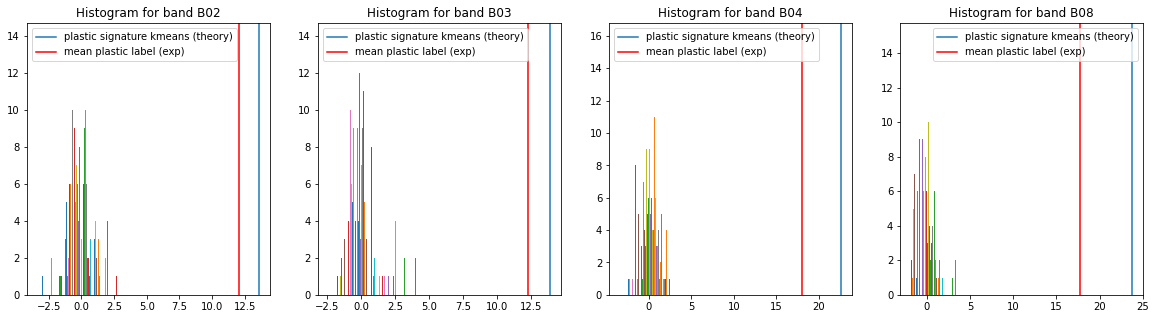

img ID 1


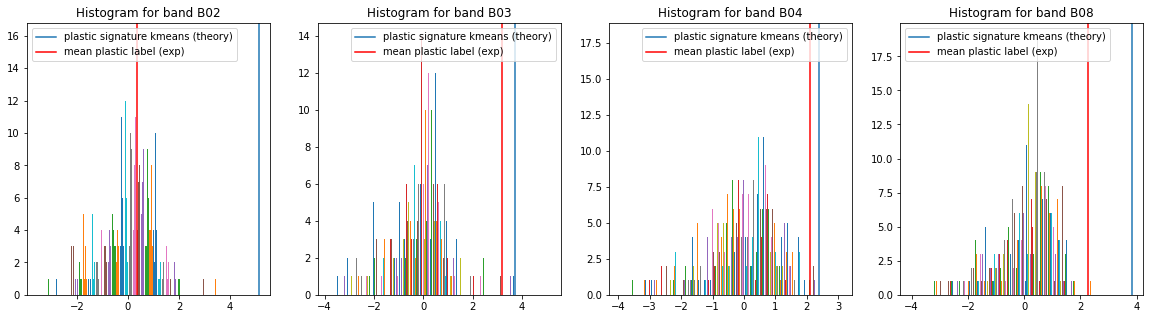

img ID 2


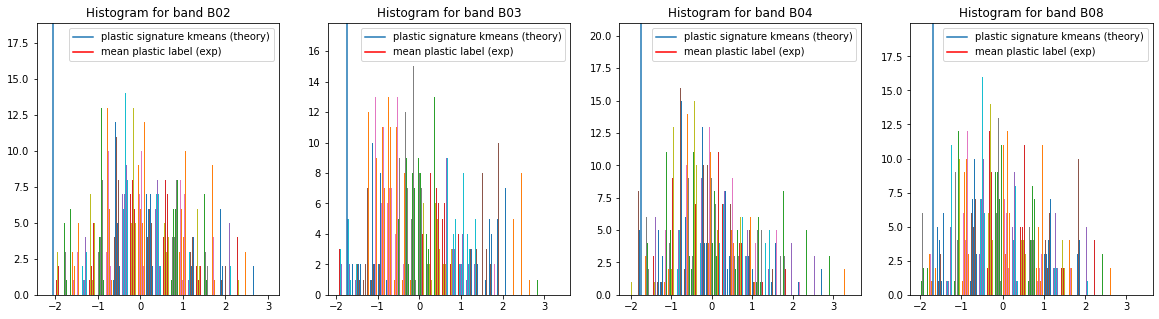

img ID 3


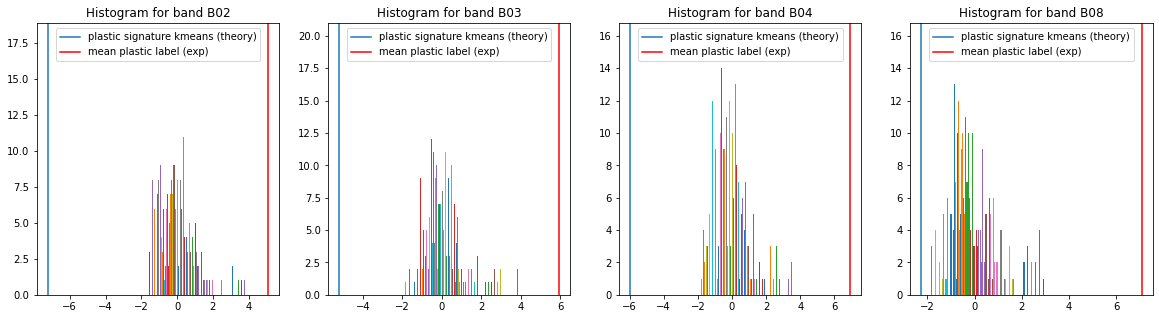

img ID 4


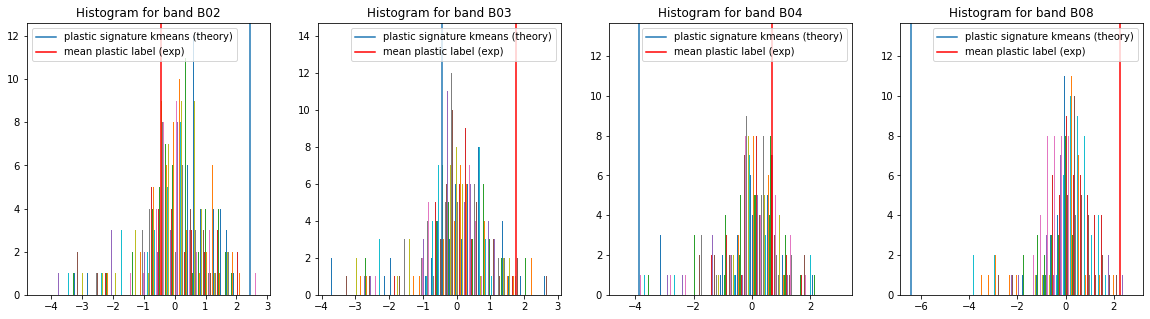

img ID 5


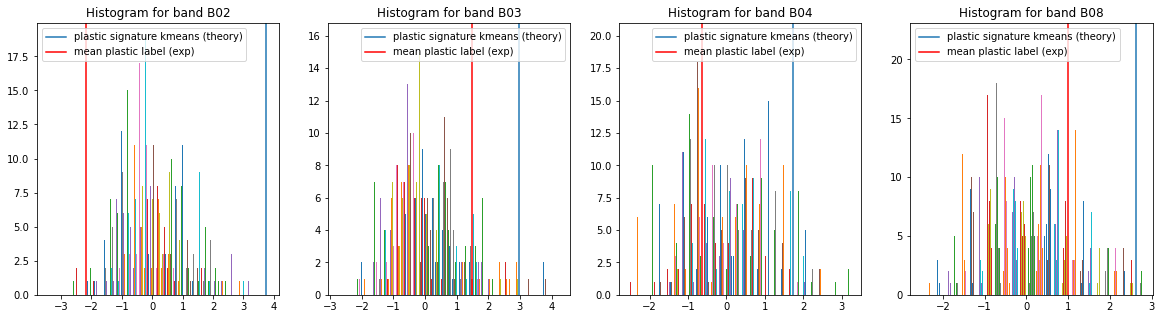

In [9]:
for i in range(len(labels_l)):
    print('img ID', i)
    plot_hist_water_plastic(i,data_per_band,labels_l,plastic_sign,bands, log = 'False')

img ID 0


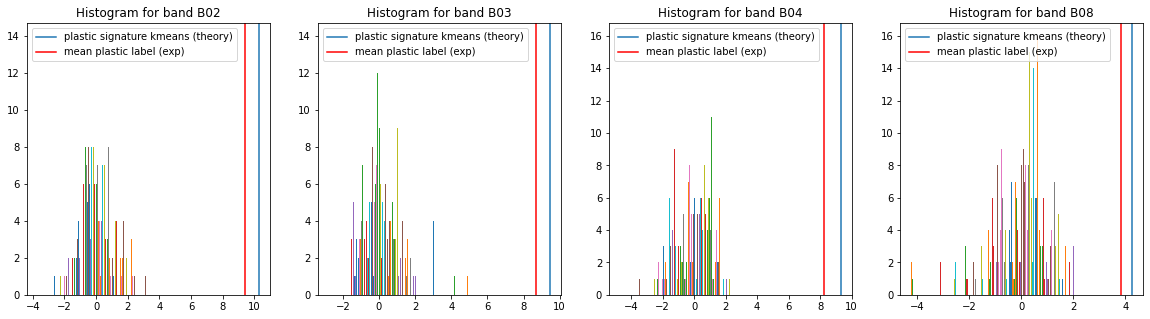

img ID 1


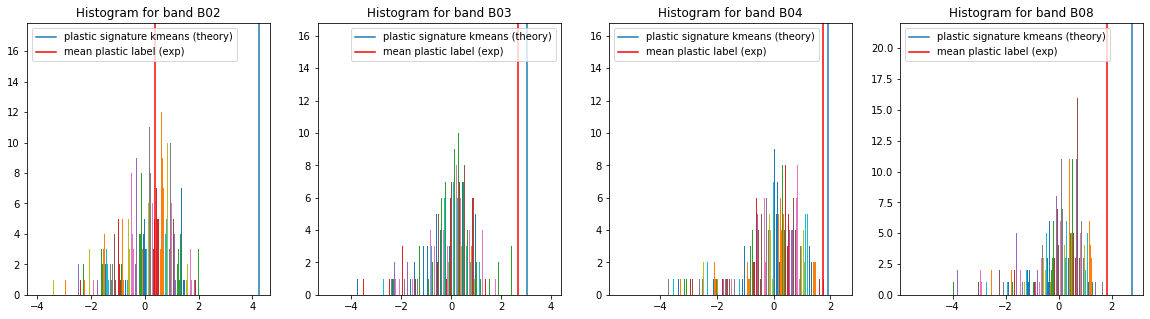

img ID 2


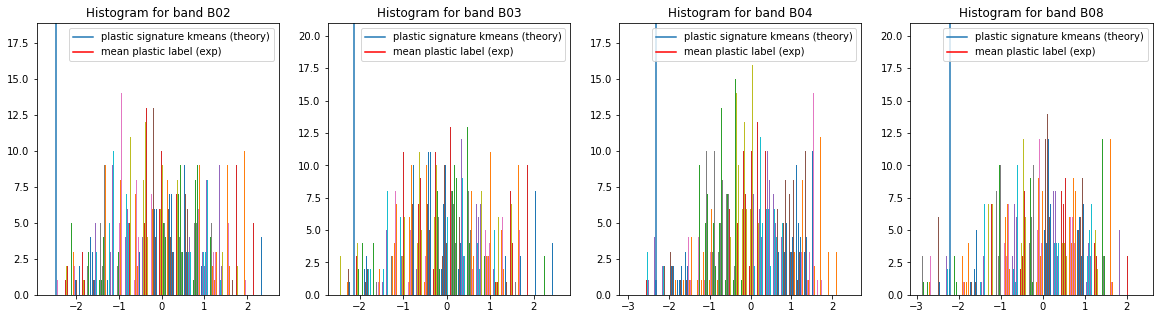

img ID 3


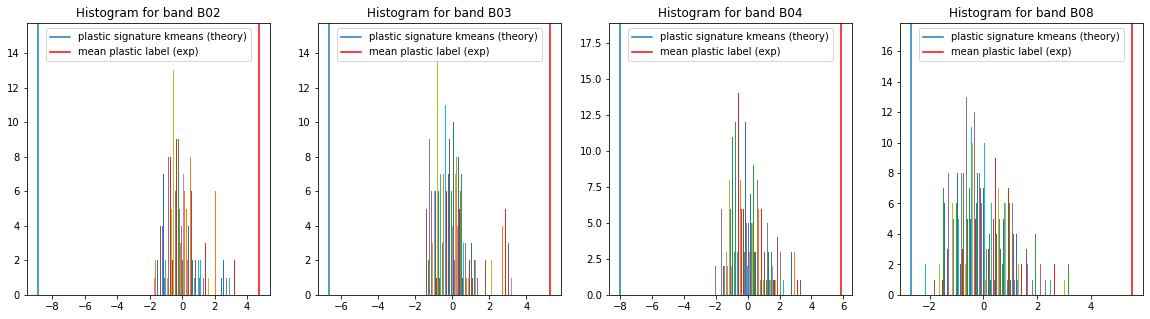

img ID 4


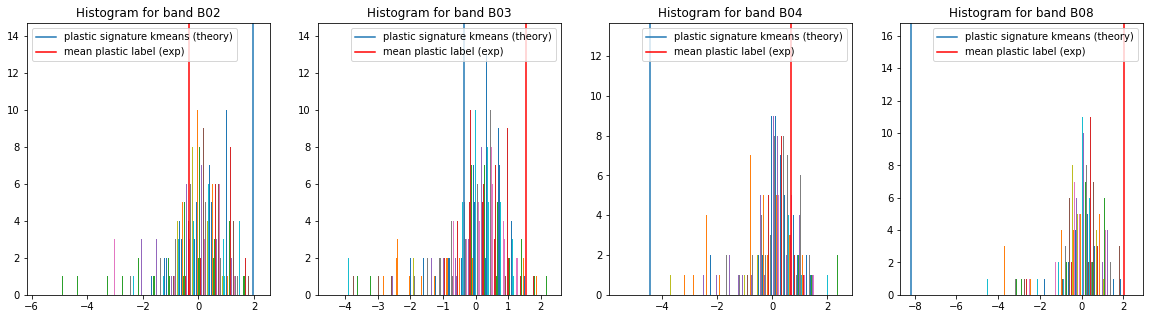

img ID 5


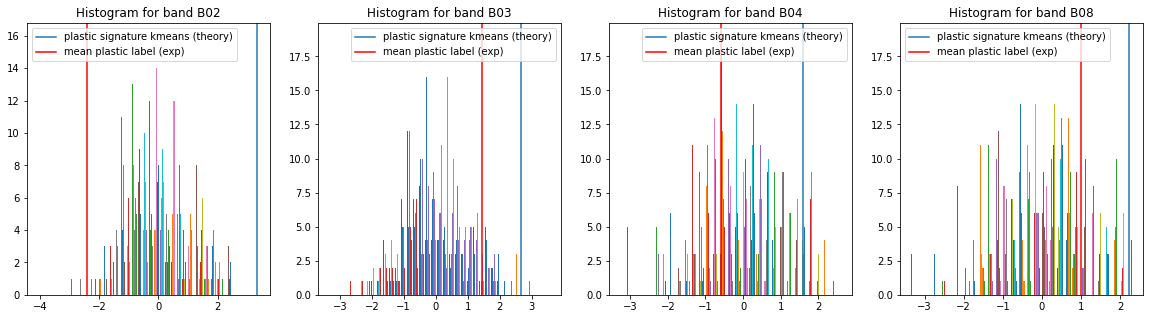

In [43]:
for i in range(len(labels_l)):
    print('img ID', i)
    plot_hist_water_plastic(i,data_per_band,labels_l,plastic_sign,bands, log = 'True')

L'eau réfléchit moins près des littoraux que dans l'océan (cf travail de Basile). De plus, on sait que le plastic réfléchit plus que l'eau. On considère donc pour l'eau seulement la signature spectrale dans l'océan, qui est la plus critique (plus proche de la signature de l'eau du plastique).

On a alors représenté les histogrammes des pixels eau pour chaque bandes d'intérêt, et on a comparé avec les signatures spectrales du plastique théorique (mesurée via kmeans), et expérimentale (label plastique sur cette même image). On voit qu'il y a une séparation nette entre l'océan et la signature spectrale du plastique. On va essayer d'effectuer un test d'hypothèses.

On suppose dans un premier temps que l'anomalie (plastique) est un signal constant déterministique connu A. On prendra comme valeurs celles obtenues via le kmeans.

Déterminons la distribution des pixels eau.

### Cette partie est obsolète, je suis partie du principe que c'était lognormal. Ne pas regarder.

In [8]:
# test de normalité

def normality_check(x):
    k2, p = stats.normaltest(x)
    alpha = 1e-3
    print(p)
    if p < alpha:
        print("it doesn't follow a normal distribution")
    else:
        print("it follows a normal distribution")

In [24]:
# test plusieurs lois
def distribution_check(data,j):
    y, x = np.histogram(data, bins='auto', density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    dist_names = ['norm','lognorm'] #'beta','gamma','lognorm','chi2']
    sse = np.inf
    sse_thr = 0.10

# Pour chaque distribution
    for name in dist_names:

    # Modéliser
        dist = getattr(stats, name)
        param = dist.fit(data)

        # Paramètres
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]

        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        # SSE
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est ddiminué, enregistrer la loi
        if model_sse < sse :
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_name = name

        # Si en dessous du seuil, quitter la boucle
        if model_sse < sse_thr :
            break
    plt.figure(figsize=(10,6))
    plt.title('Water (noise) histogram for band {n}'.format(n=bands[j]))
    plt.plot(x, y, label="Données")
    plt.plot(x, best_pdf, label=best_name, linewidth=3)
    plt.legend(loc='upper right')
    plt.show()

    # Détails sur la loi sélectionnée
    print("Selected Model : ", best_name)
    print("Loc. param. : ", best_loc)
    print("Scale param. : ", best_scale)
    print("Other arguments : ", best_arg)
    print("SSE : ", sse)

<Figure size 432x288 with 0 Axes>

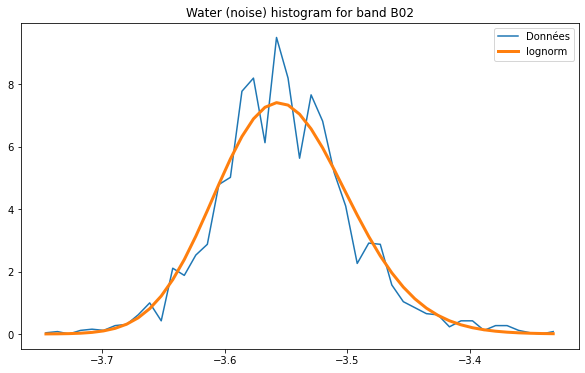

Selected Model :  lognorm
Loc. param. :  -4.32449345214869
Scale param. :  0.7719430871627765
Other arguments :  (0.06986440916724726,)
SSE :  20.549249870645088


<Figure size 432x288 with 0 Axes>

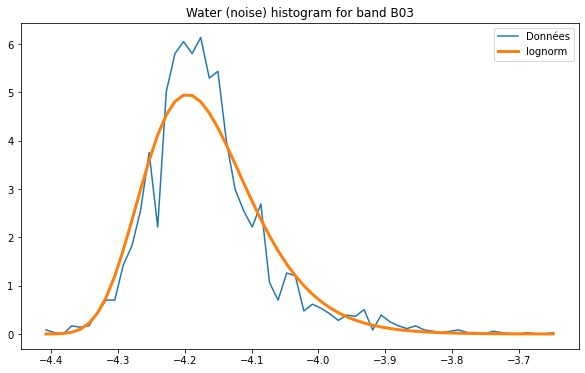

Selected Model :  lognorm
Loc. param. :  -4.525770809304818
Scale param. :  0.34851332930409595
Other arguments :  (0.2375804992189744,)
SSE :  14.929654765294671


<Figure size 432x288 with 0 Axes>

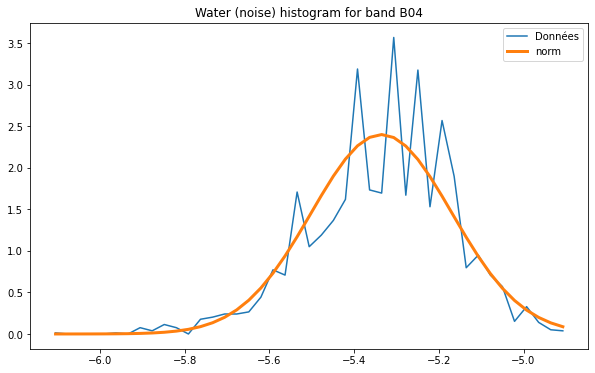

Selected Model :  norm
Loc. param. :  -5.33529303202502
Scale param. :  0.16629103944854498
Other arguments :  ()
SSE :  7.40305468842253


<Figure size 432x288 with 0 Axes>

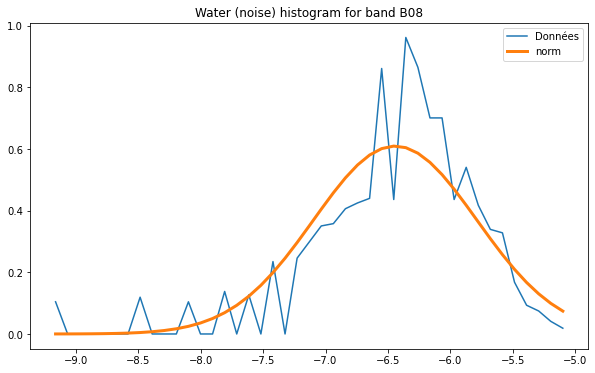

Selected Model :  norm
Loc. param. :  -6.442518684540704
Scale param. :  0.6541303851219075
Other arguments :  ()
SSE :  0.5977566805390362


In [26]:
# histogrammes pour chaque bande
m,n = labels_l[0].shape
for j in range(len(data_per_band[0])):
    plt.figure()
    x=np.log(np.array(data_per_band[0][j]).reshape(m,n)[:,150:])
    
    distribution_check(x.flatten(),j)
    

Pour les bandes B02 et B03, la distribution des pixels eau suit une loi log-normale. Pour la bande B04, la distribution suit une loi normale. Enfin, pour la bande B08, la distribution suit une loi gamma.

En testant sur plusieurs images, on voit souvent apparaitre des lognorms, beta et chi2... Il faudrait choisir la loi qui revient le plus souvent. Je pense que modéliser par une lognorm peut être une bonne idée.

On va commencer par réaliser un test d'hypothèses pour la bande B04 car loi plus simple. On suppose H0 : x(n)=w(n) (bruit gaussien), H1: x(n)=w(n)+A, ce qui est un modèle simpliste.

On commence par centrer et réduire la valeur des pixels de l'image (car cf plus loin ça nous pose pb pour généraliser)

### Début test d'hypothèse simple sur toutes les bandes log-normalisées. Partie à peu près propre, à regarder

In [59]:
# choix de seuil basé sur une image (toutes les bandes spectrales)

def simple_threshold_choice(img, label, N, chosen_PFA):
    print('----------- threshold choice --------------')
    print(' Window =', (N,N) )
    print('chosen PFA : ', chosen_PFA)
    seuils = []
    band = ['B02', 'B03', 'B04', 'B08']
    h, w = label.shape
    i = 0
    for b in img : 
        
        print('----------- band :', band[i])
        
        # data preprocessing
        x_nc=np.array(b)
        x, mu_1, sigma_1 = standardize(x_nc)  # normalize data
        plt.figure()
        plt.imshow(x.reshape(h,w))
        mu = np.nanmean(x)
        sigma = np.nanstd(x)
        print('mean standardized data', mu)
        print('sigma standardized data', sigma)
        A = np.mean(x[np.where(label.flatten() > 0.5)])
        print('label standardized plastic signature = ', A)
        m_iter = 1000
        
    
        PFA = np.zeros((1,m_iter))
        PD = np.zeros((1,m_iter))
        T00 = np.zeros((1,m_iter))
        T11 = np.zeros((1,m_iter))
        seuil = np.zeros((1,m_iter))
        # Monte Carlo simulation to get the theoretical threshold
        for m in range(m_iter):
            x0 = np.random.normal(mu, sigma, size=(N,N))
            x1 = np.random.normal(mu+A, sigma, size=(N,N))
            T0 = np.mean(x0.flatten())
            T1 = np.mean(x1.flatten())
            T00[0,m] = T0
            T11[0,m] = T1
            l=-1
            step = 0.003
            for k in range(m_iter):
                seuil[0,k]=l
                if T0>l:
                    PFA[0,k]=PFA[0,k]+1
                if T1>l:
                    PD[0,k]=PD[0,k]+1
                l +=step
        PFA = PFA/m_iter
        PD = PD/m_iter

        # verify distribution
        print('----- check distribution of statistic------')
        plt.figure()
        plt.hist(T11[0], bins='auto')
        plt.title('statistic distribution under H1, mean = {m}, sigma = {s}'.format(m=round(np.mean(T11[0]),3),s=round(np.std(T11[0]),3)))

        
        # get the threshold according to the theoretical distribution we get
        s = norm.ppf(1-chosen_PFA, 0, sigma/N) # seuil = inverse cdf, cf rapport final
        print('threshold = ', s)
        seuils.append(s)
        
        # plot the PFA, PD and ROC curves, with the threshold
        print('--- plot PFA, PD, ROC curves-------')
        plt.figure(figsize=(20,4))
        plt.subplot(131)
        plt.plot(seuil[0], PFA[0])
        plt.title('PFA=f(seuil)')
        plt.axvline(x = s, label = 'threshold with chosen PFA', color='r')
        
        plt.subplot(132)
        plt.plot(seuil[0], PD[0])
        plt.title('PD=f(seuil)')
        plt.axvline(x = s, label = 'threshold with chosen PFA', color='r')
        plt.subplot(133)
        plt.plot(PFA[0], PD[0])
        plt.title('PD=f(PFA)')
        
        
        i+=1
        
        
        plt.show()
    return seuils

----------- threshold choice --------------
 Window = (3, 3)
chosen PFA :  0.05
----------- band : B02
mean standardized data -1.307407497578229e-16
sigma standardized data 1.0
label standardized plastic signature =  1.8152238787779886
----- check distribution of statistic------
threshold =  0.5482845423171574
--- plot PFA, PD, ROC curves-------


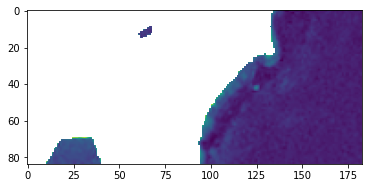

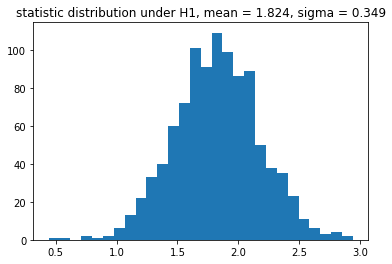

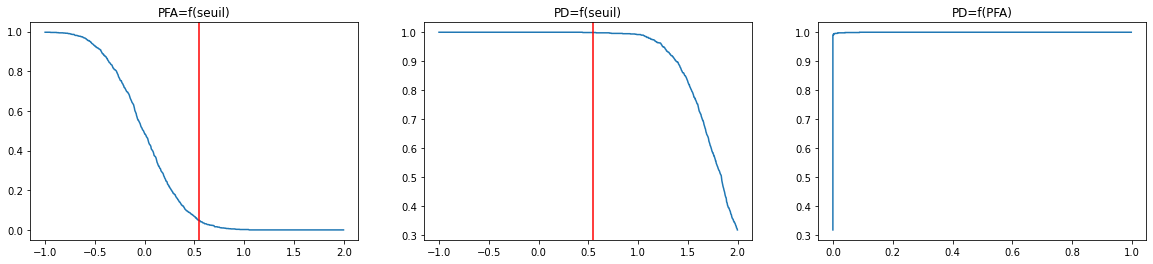

----------- band : B03
mean standardized data 5.3182677867588974e-17
sigma standardized data 1.0
label standardized plastic signature =  0.7885054161762474
----- check distribution of statistic------
threshold =  0.5482845423171574
--- plot PFA, PD, ROC curves-------


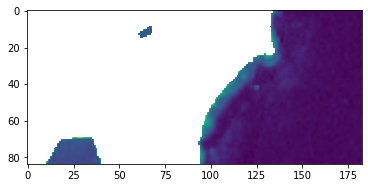

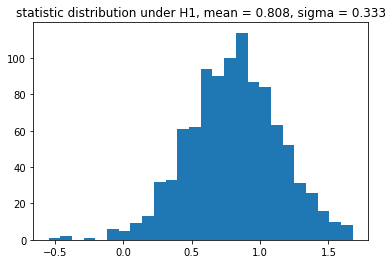

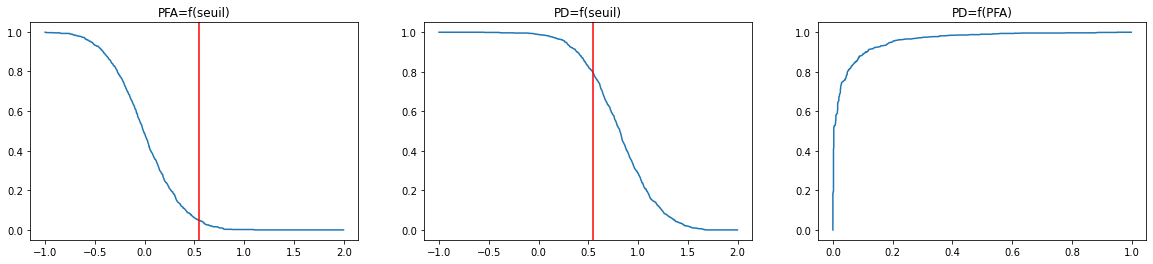

----------- band : B04
mean standardized data -4.875078804528989e-17
sigma standardized data 1.0
label standardized plastic signature =  0.8839239320179854
----- check distribution of statistic------
threshold =  0.5482845423171574
--- plot PFA, PD, ROC curves-------


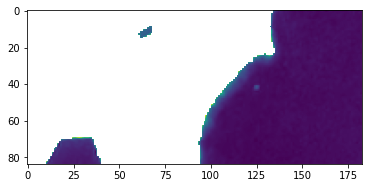

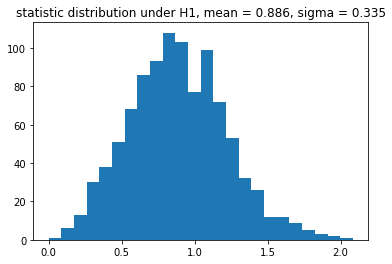

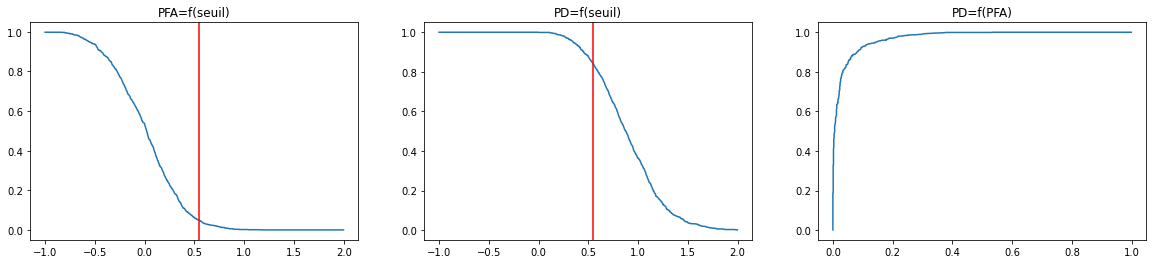

----------- band : B08
mean standardized data -1.7727559289196326e-17
sigma standardized data 1.0
label standardized plastic signature =  0.9821579586276723
----- check distribution of statistic------
threshold =  0.5482845423171574
--- plot PFA, PD, ROC curves-------


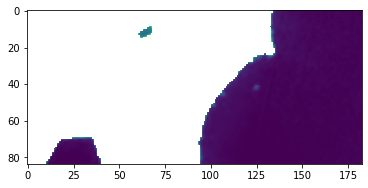

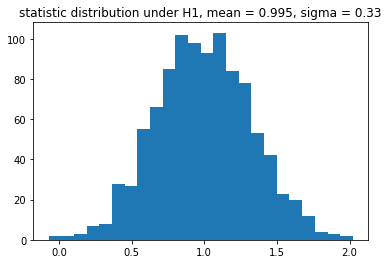

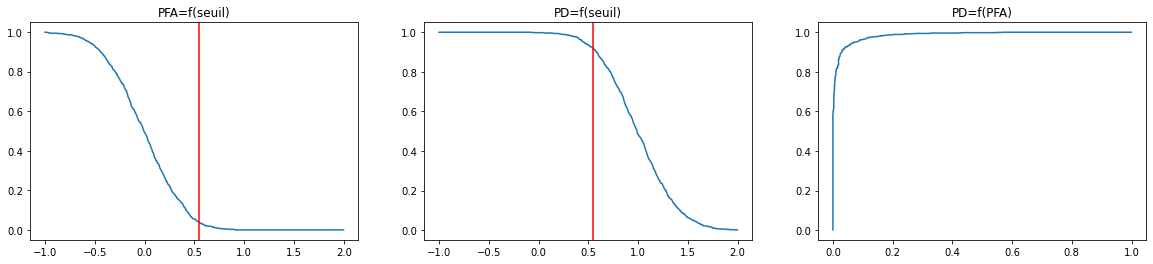

In [64]:
N = 3
seuils_img_0 = simple_threshold_choice(data_per_band[0], labels_l[0], N, 0.05)

In [98]:
def simple_hyp_test(img, label, N, seuils):
    m, n = label.shape
    result_img = np.zeros((m,n,len(img)))
    bands = ['B02', 'B03', 'B04', 'B08']
    for t in range(len(img)):
        seuil_test = seuils[t]
        
        # pre processing
        band = img[t]
        x_nc=np.array(band)
        x, _, _ = standardize(x_nc)  # normalize data
        x = x.reshape(m,n)
        
        for i in range(m-N):
            for j in range(n-N):
                T = np.mean(x[i:i+N,j:j+N].flatten())
                if T>seuil_test:
                    result_img[i,j,t]+=1

    # plot predictions per bands
    print('----- predictions per band -----')
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(result_img[:,:,0])
    plt.title('prediction band {i}'.format(i=bands[0]))
    plt.subplot(222)
    plt.imshow(result_img[:,:,1])
    plt.title('prediction band {i}'.format(i=bands[1]))
    plt.subplot(223)
    plt.imshow(result_img[:,:,2])
    plt.title('prediction band {i}'.format(i=bands[2]))
    plt.subplot(224)
    plt.imshow(result_img[:,:,3])
    plt.title('prediction band {i}'.format(i=bands[3]))
    plt.show()
    
    # plot predictions all bands together
    print('---- plot result all bands together ----')
    all_bands = result_img[:,:,0]+result_img[:,:,1]+result_img[:,:,2]+result_img[:,:,3]
    plt.figure()
    plt.imshow(all_bands)
    plt.show()
    
    # compare with the label
    res = np.where(all_bands > 2, 1, 0) 
#     res = np.where(all_bands <= 2, res, 1) 

    print('---- plot result thresholded ----')
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(res-label)
    
    print('---- plot result label ----')
    plt.subplot(122)
    plt.imshow(label)
    plt.show()
    
    # calculate jaccard score
    score = jaccard_score(label.flatten(), res.flatten())
    print('jaccard score', score)
    

----- predictions per band -----


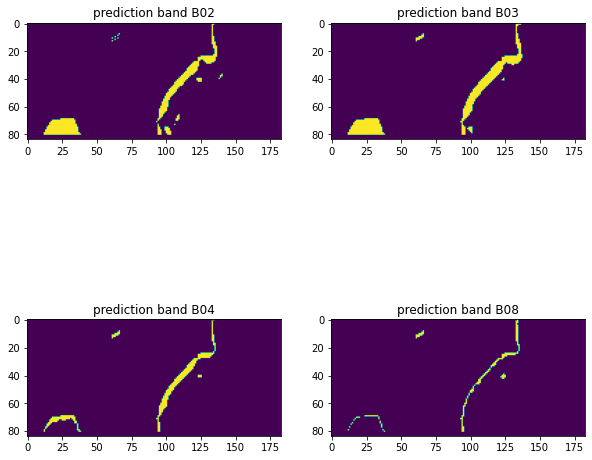

---- plot result all bands together ----


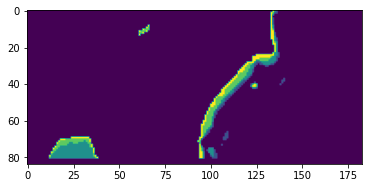

---- plot result thresholded ----
---- plot result label ----


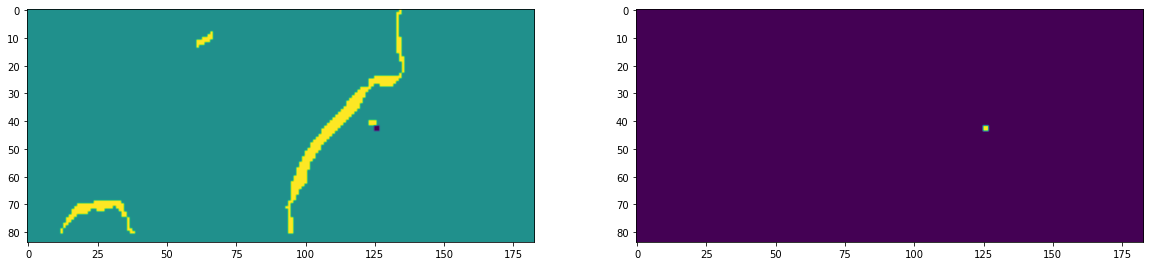

jaccard score 0.0


In [99]:
simple_hyp_test(data_per_band[0], labels_l[0], N, seuils_img_0)

Il y a un problème de labellisation. La prédiction est bien correcte. Mais on ne peut pas calculer le coefficient de Jaccard.

## Partie encore brouillon, ne pas regarder

-4.875078804528989e-17
0.8839239320179854


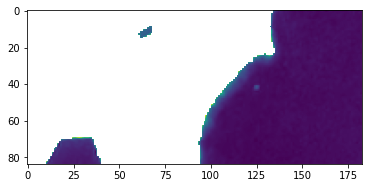

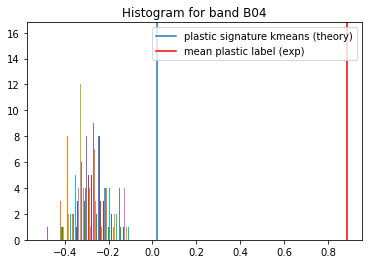

In [11]:
m, n = labels_l[0].shape
x_nc=np.array(data_per_band[0][2])
mu_1 = np.nanmean(x_nc.reshape(m,n))
sigma_1 = np.nanstd(x_nc.reshape(m,n))

x = np.array([(e-mu_1)/sigma_1 for e in x_nc])
mu = np.nanmean(x)
sigma = np.nanstd(x)
print(mu)

# print('moy', mu)
# print('sigma', sigma)
A = np.mean(x[np.where(labels_l[0].flatten() > 0.5)])
print(A)
plt.imshow(x.reshape(m,n))

plt.figure()
plt.hist(x.reshape(m,n)[:,150:], bins='auto')
plt.axvline(x=plastic_sign[2], label = 'plastic signature kmeans (theory)')
plt.axvline(x=A, color='r', label='mean plastic label (exp)')
plt.title('Histogram for band {n}'.format(n=bands[2]))
plt.legend()

Text(0.5, 1.0, 'PD=f(PFA)')

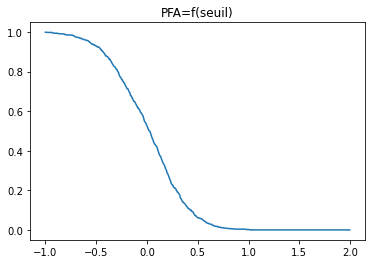

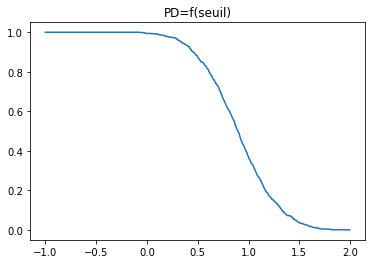

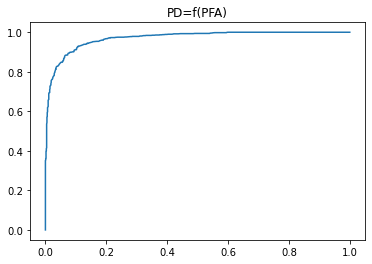

In [12]:
N = 3
m_iter = 1000
PFA = np.zeros((1,m_iter))
PD = np.zeros((1,m_iter))
T00 = np.zeros((1,m_iter))
T11 = np.zeros((1,m_iter))
seuil = np.zeros((1,m_iter))# simulation par Monte Carlo
for m in range(m_iter):
    x0 = np.random.normal(mu, sigma, size=(N,N))
    x1 = np.random.normal(mu+A, sigma, size=(N,N))
    T0 = np.mean(x0.flatten())
    T1 = np.mean(x1.flatten())
    T00[0,m] = T0
    T11[0,m] = T1
    l=-1
    step = 0.003
    for k in range(m_iter):
        seuil[0,k]=l
        if T0>l:
            PFA[0,k]=PFA[0,k]+1
        if T1>l:
            PD[0,k]=PD[0,k]+1
        l +=step
PFA = PFA/m_iter
PD = PD/m_iter

plt.figure()
plt.plot(seuil[0], PFA[0])
plt.title('PFA=f(seuil)')

plt.figure()
plt.plot(seuil[0], PD[0])
plt.title('PD=f(seuil)')

plt.figure()
plt.plot(PFA[0], PD[0])
plt.title('PD=f(PFA)')

On va prendre un seuil = 0.005 pour avoir une PFA inférieure à 10%.

New : après normalisation, on prend un seuil de 0.5 pour avoir PFA = 10% et PD=90%

mean statistic 0.003656688795012629
mean theory -4.875078804528989e-17
standard deviation statistic 0.3395250356399852
standard deviation theory 0.3333333333333333
percentage error mean: 7500778842006786.0
percentage error sdt: -0.0001857510691995568


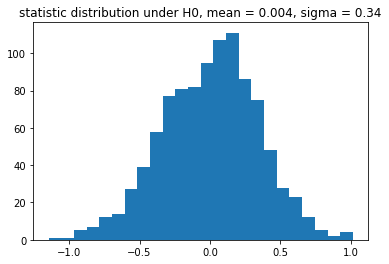

In [13]:
import math
from scipy.stats import norm
plt.hist(T00[0], bins='auto')
plt.title('statistic distribution under H0, mean = {m}, sigma = {s}'.format(m=round(np.mean(T00[0]),3),s=round(np.std(T00[0]),3)))

abs_x = np.linspace(0,0.01, 1000)
print('mean statistic', np.mean(T00[0]))
print('mean theory',mu)
print('standard deviation statistic',np.std(T00[0]))
print('standard deviation theory',sigma/math.sqrt(N**2))

print('percentage error mean:',(mu-np.mean(T00[0]))/mu*100 )
print('percentage error sdt:',(sigma/math.sqrt(N**2)-np.std(T00[0]))/(sigma/math.sqrt(N**2)*100) )
# plt.plot(abs_x,norm.pdf(abs_x,mu,sigma/math.sqrt(N)))

mean statistic 0.8936019904891762
mean theory 0.8839239320179854
standard deviation statistic 0.33630223259843595
standard deviation theory 0.3333333333333333
percentage error mean: 1.9852106723279748e+16
percentage error sdt: -8.906697795307895e-05


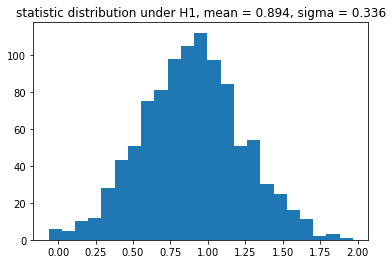

In [14]:
plt.hist(T11[0], bins='auto')
plt.title('statistic distribution under H1, mean = {m}, sigma = {s}'.format(m=round(np.mean(T11[0]),3),s=round(np.std(T11[0]),3)))

abs_x = np.linspace(0,0.01, 1000)
print('mean statistic', np.mean(T11[0]))
print('mean theory',mu+A)
print('standard deviation statistic',np.std(T11[0]))
print('standard deviation theory',sigma/math.sqrt(N**2))

print('percentage error mean:',(mu+A-np.mean(T11[0]))/mu*100 )
print('percentage error sdt:',(sigma/math.sqrt(N**2)-np.std(T11[0]))/(sigma/math.sqrt(N**2)*100) )
# plt.plot(abs_x,norm.pdf(abs_x,mu+A,sigma/math.sqrt(N)))

Il y a un problème avec les graphes mais on remarque que les statistiques suivent bien les bonnes lois. C'est bon signe pour la suite.

0.008312661804367887


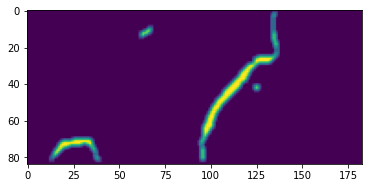

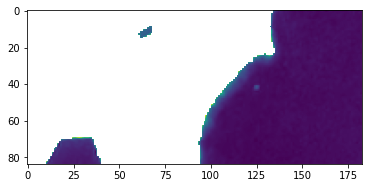

In [15]:
m, n = labels_l[0].shape
seuil_test = .5
x_nc=np.array(data_per_band[0][2]).reshape(m,n)
mu_1 = np.nanmean(x_nc.reshape(m,n))
print(mu_1)
sigma_1 = np.nanstd(x_nc.reshape(m,n))

x = np.array([(e-mu_1)/sigma_1 for e in x_nc])

# print(len(x))
result_img = np.zeros((m,n))
for i in range(m-N):
    for j in range(n-N):
        T = np.mean(x[i:i+N,j:j+N].flatten())
        if T>seuil_test:
            result_img[i:i+N,j:j+N]+=1

plt.figure()
plt.imshow(result_img)

plt.figure()
plt.imshow(x)


Cela a fonctionné avec un seuil plus faible qu'au départ (donc il va falloir choisir la PFA optimale qu'on souhaite avoir...). Il faut également prendre la bonne valeur de N.

Test sur d'autres images

0.008312661804367887
0.020087866276506335
0.06787330588011942
0.04861182456872035
0.04168809715814706
0.016650950763674937


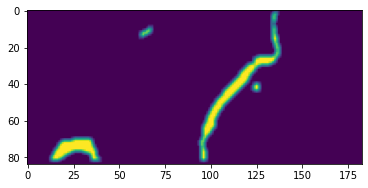

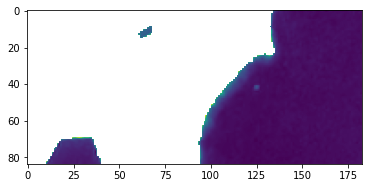

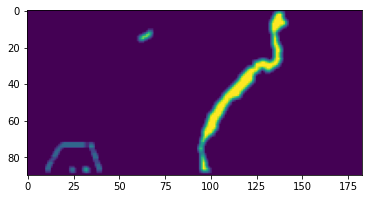

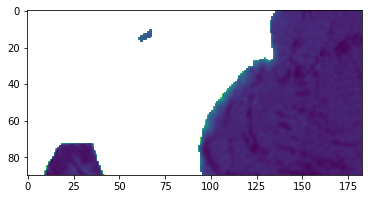

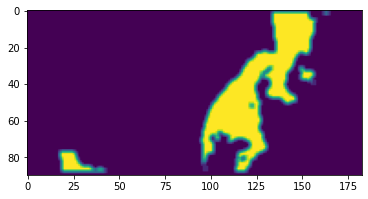

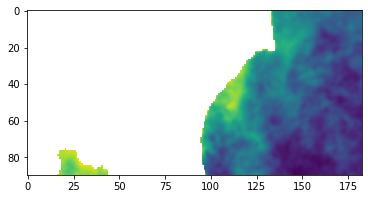

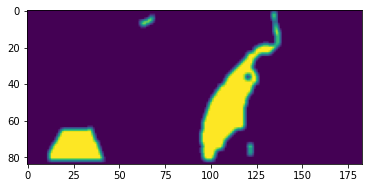

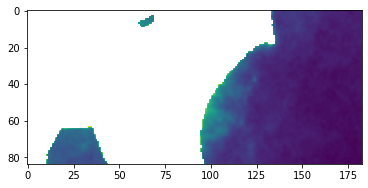

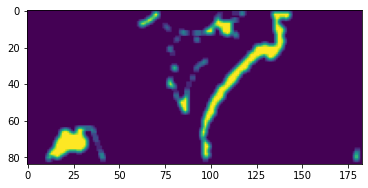

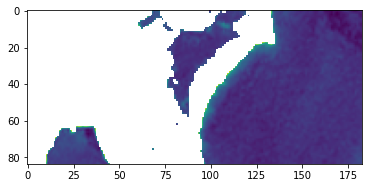

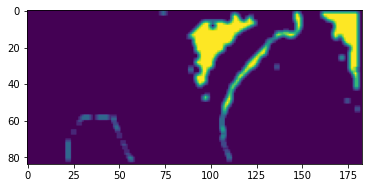

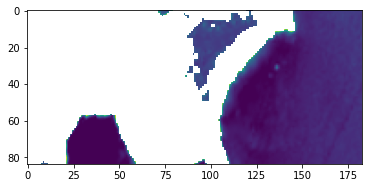

In [16]:
# img_name = listdir(data_dir)
moys_a = []
std_a = []

moys_w = []
std_w = []

seuil_test = .2
im_l=[]
lab_l=[]
for k in range(len(data_per_band)-2):
#     if e!='label' and e!='Mytilene':
#         data_im, label_im = utils.get_batch(bands, e, all = False)
#         moys_a.append(np.mean(data_im[:,:,2].flatten()))
#         std_a.append(np.std(data_im[:,:,2].flatten()))
        
#         moys_w.append(np.mean(data_im[:,150:,2].flatten()))
#         std_w.append(np.std(data_im[:,150:,2].flatten()))
        
#         im_l.append(data_im)
#         lab_l.append(label_im)
    m, n = labels_l[k].shape
    x_nc=np.array(data_per_band[k][2])
    mu_1 = np.nanmean(x_nc.reshape(m,n))
    print(mu_1)
    sigma_1 = np.nanstd(x_nc.reshape(m,n))
    x = np.array([(e-mu_1)/sigma_1 for e in x_nc.flatten()]).reshape((m,n))
       
    result_img = np.zeros((m,n))
    for i in range(m-N):
        for j in range(n-N):
            T = np.mean(x[i:i+N,j:j+N].flatten())
            if T>seuil_test:
                result_img[i:i+N,j:j+N]+=1

    plt.figure()
    plt.imshow(result_img)

    plt.figure()
    plt.imshow(x.reshape(m,n))
        
# plt.figure()        
# plt.plot(moys_a, label='moy all')
# plt.plot(moys_w, label='moy water')
# plt.legend()


# plt.figure()        
# plt.plot(std_a, label='std all')
# plt.plot(std_w, label='std water')
# plt.legend()

-4.875078804528989e-17
0.8839239320179854
0.0
0.1651621188555366
-5.861872893719153e-17
nan
-5.4407631069835386e-17
0.7033773135186585
-1.794753058247285e-16
-0.12443281459028144
-4.7336643048556293e-17
-0.09014149491318463


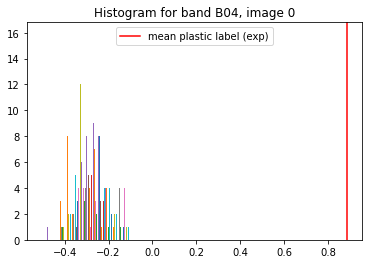

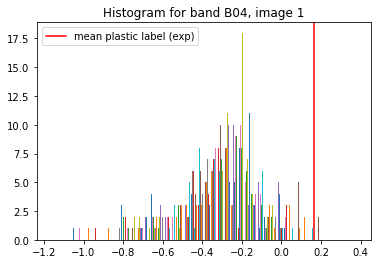

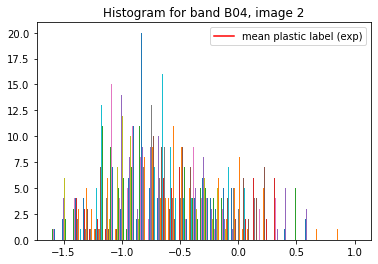

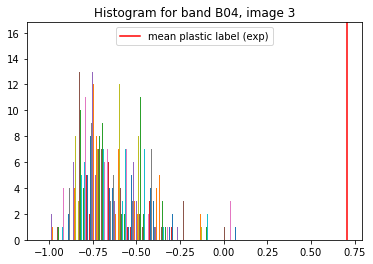

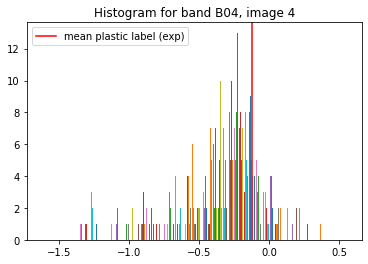

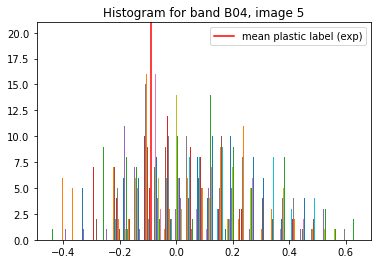

In [138]:
pix_eau = []
# i=0
for j in range(len(data_per_band)-2):
    m, n = labels_l[j].shape
    x_nc=np.array(data_per_band[j][2])
    mu_1 = np.nanmean(x_nc)
    sigma_1 = np.nanstd(x_nc)

    x = np.array([(e-mu_1)/sigma_1 for e in x_nc])
    mu = np.nanmean(x)
    sigma = np.nanstd(x)
    print(mu)

    # print('moy', mu)
    # print('sigma', sigma)
    A = np.mean(x[np.where(labels_l[j].flatten() > 0.5)])
    print(A)
#     plt.imshow(x.reshape(m,n))

    plt.figure()
    plt.hist(x.reshape(m,n)[:,150:], bins='auto')
#     plt.axvline(x=plastic_sign[2], label = 'plastic signature kmeans (theory)')
    plt.axvline(x=A, color='r', label='mean plastic label (exp)')
    plt.title('Histogram for band {n}, image {j}'.format(n=bands[2], j = j))
    plt.legend()

La distribution semble être la même pour l'eau, cependant les moyennes changent en fonction du bruit, idem pour A. Il faut implémenter un détecteur pour A inconnu, sigma et mu inconnus.

[0.0037 0.005  0.0051 ... 0.0056 0.0057 0.0058]
moy 0.004883874472315339
sigma 0.000787329584189725


Text(0.5, 1.0, 'PD=f(PFA)')

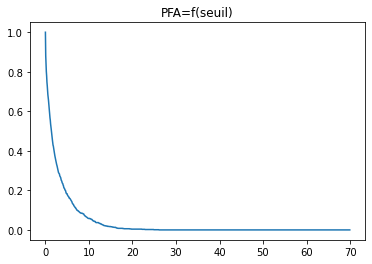

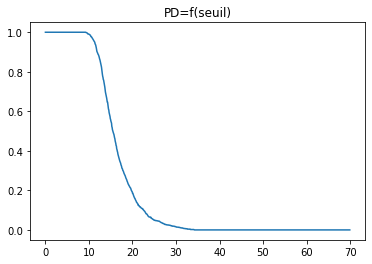

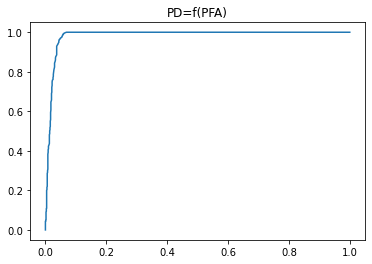

In [88]:
A = 1.85e-02
m, n = labels_l[0].shape
x_water=np.array(data_per_band[2]).reshape(m,n)[:,150:]
print(x_water.flatten())
mu = np.mean(x_water)
sigma = np.std(x_water)
print('moy', mu)
print('sigma', sigma)

sigma2 = sigma**2
N = 2
m_iter = 1000
PFA = np.zeros((1,m_iter))
PD = np.zeros((1,m_iter))
T00 = np.zeros((1,m_iter))
T11 = np.zeros((1,m_iter))
seuil = np.zeros((1,m_iter))
# simulation par Monte Carlo
for m in range(m_iter):
    x0 = np.random.normal(0, sigma, size=(1,N))
    x1 = np.random.normal(0+A, sigma, size=(1,N))
    
    # estimated A
    A_est_0 = np.mean([xi for xi in x0])
    A_est_1 = np.mean([xi for xi in x1])
    
    # sigma under H0
    sigma2_00 = np.mean([(xi)**2 for xi in x0])
    sigma2_10 = np.mean([(xi-A_est_0)**2 for xi in x0])
    
    # sigma under H1
    sigma2_01 = np.mean([(xi)**2 for xi in x1])
    sigma2_11 = np.mean([(xi-A_est_1)**2 for xi in x1])
    
    T0 = N*math.log(sigma2_00/sigma2_10)
    T1 = N*math.log(sigma2_01/sigma2_11)
    T00[0,m] = T0
    T11[0,m] = T1
    l=0
    step = 0.07
    for k in range(m_iter):
        seuil[0,k]=l
        if T0>l:
            PFA[0,k]=PFA[0,k]+1
        if T1>l:
            PD[0,k]=PD[0,k]+1
        l +=step

# print(A_est_0-A_est_1)
# print(A)
PFA = PFA/m_iter
PD = PD/m_iter

plt.figure()
plt.plot(seuil[0], PFA[0])
plt.title('PFA=f(seuil)')

plt.figure()
plt.plot(seuil[0], PD[0])
plt.title('PD=f(seuil)')

plt.figure()
plt.plot(PFA[0], PD[0])
plt.title('PD=f(PFA)')

L'estimation de A est bonne. On prend seuil = 20

mean statistic 2.761941848586225
mean theory 1
standard deviation statistic 3.6617558018827556
standard deviation theory 1.4142135623730951
percentage error mean: -176.1941848586225
percentage error sdt: -158.92523585604803


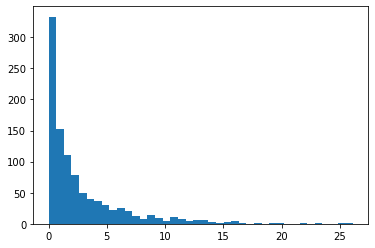

In [89]:
plt.hist(T00[0], bins='auto')
abs_x = np.linspace(0,0.01, 1000)
mean_stat = np.mean(T00[0])
mean_theory = 1

sdt_stat = np.std(T00[0])
sdt_theory = math.sqrt(2)

print('mean statistic', mean_stat)
print('mean theory',mean_theory)
print('standard deviation statistic',sdt_stat)
print('standard deviation theory',sdt_theory)

print('percentage error mean:',100*(mean_theory-mean_stat)/mean_theory)
print('percentage error sdt:',100*(sdt_theory-sdt_stat)/sdt_theory )
# plt.plot(abs_x,norm.pdf(abs_x,mu,sigma/math.sqrt(N)))

Ca suit bien une loi du chi 2 à 1 ddl.

mean statistic 16.520298667205317
mean theory 1105.231956382815
standard deviation statistic 4.38020140423073
standard deviation theory 4418.92782553126
percentage error mean: 98.50526411475899
percentage error sdt: 99.90087637596336


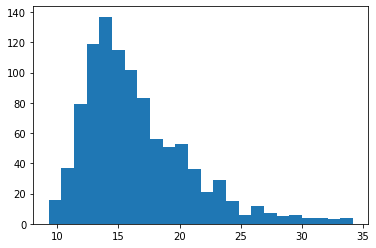

In [90]:
plt.hist(T11[0], bins='auto')
abs_x = np.linspace(0,0.01, 1000)

mean_stat = np.mean(T11[0])
mean_theory = 1+N*((A)**2)/(sigma2)

sdt_stat = np.std(T11[0])
sdt_theory = 2*(1+2*N*((A)**2)/(sigma2))

print('mean statistic', mean_stat)
print('mean theory',mean_theory)
print('standard deviation statistic',sdt_stat)
print('standard deviation theory',sdt_theory)

print('percentage error mean:',100*(mean_theory-mean_stat)/mean_theory)
print('percentage error sdt:',100*(sdt_theory-sdt_stat)/sdt_theory )
# plt.plot(abs_x,norm.pdf(abs_x,mu+A,sigma/math.sqrt(N)))

C:\Users\ALINA\anaconda3\envs\MCE_ML\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


(array([  1.,   1.,   1.,   2.,   6.,  15.,  29.,  31.,  82.,  98., 166.,
        151., 234., 234., 298., 364., 405., 414., 308., 431., 389., 377.,
        303., 223., 170., 152., 101.,  43.,  56.,  44.,  37.,  27.,  27.,
         28.,  23.,  25.,  20.,  28.,  16.,  22.,  16.,   9.,  24.,  17.,
         19.,  14.,  10.,   8.,  18.,  13.,  16.,  17.,  14.,   9.,   8.,
          6.,   7.,  13.,   7.,  14.,  10.,  16.,   8.,  12.,   8.,   7.,
          7.,   7.,   8.,  12.,  15.,   8.,  12.,   5.,   9.,   4.,  11.,
          6.,   8.,   6.,   3.,   5.,   7.,   8.,   7.,   8.,   4.,   5.,
         10.,   3.,   4.,   6.,   0.,   4.,   7.,   5.,   4.,   2.,   3.,
          4.,   4.,   2.,   5.,   3.,   2.,   1.,   4.,   5.,   2.,   4.,
          4.,   5.,   4.,   3.,   5.,   6.,   3.,   2.,   2.,   0.,   8.,
          3.,   3.,   2.,   3.,   4.,   1.,   1.,   3.,   2.,   0.,   2.,
          2.,   2.,   2.,   3.,   2.,   2.,   2.,   2.,   3.,   0.,   2.,
          3.,   6.,   3.,   1.,   0., 

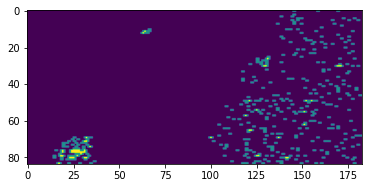

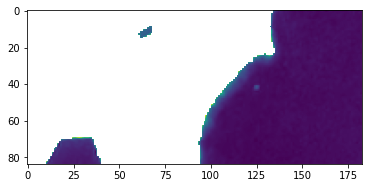

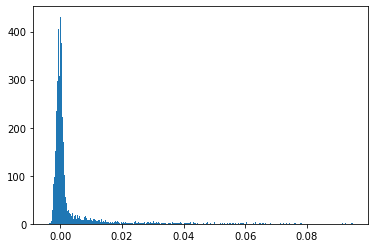

In [92]:
m, n = labels_l[0].shape
N=2
seuil_test = 15
# mu_2 = np.nanmean(data_per_band[2])
# print(mu_2)
x=np.array([d-mu for d in np.array(data_per_band[2])])
# print(np.nanmean(x.reshape(m,n)[:,150:].flatten()))
result_img = np.zeros(len(x))
A_list=[]
for k in range(len(x)-N):
    data = x[k:k+N]
     # estimated A
    A_est = np.mean([xi for xi in data])
    A_list.append(A_est)
    # sigma 
    sigma2_0 = np.mean([(xi)**2 for xi in data])
    sigma2_1 = np.mean([(xi-A_est)**2 for xi in data])
    
    T = N*math.log(sigma2_0/sigma2_1)
    if T>seuil_test:
        result_img[k:k+N]+=1

plt.figure()
plt.imshow(result_img.reshape(m,n))

plt.figure()
plt.imshow(x.reshape(m,n))

plt.figure()
plt.hist(A_list, bins='auto')

['2019_04_18_M', '2019_05_03_M', '2019_05_08_M', '2019_05_18_M', '2019_05_28_M', '2019_06_07_M', 'label', 'Mytilene']


C:\Users\ALINA\anaconda3\envs\MCE_ML\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


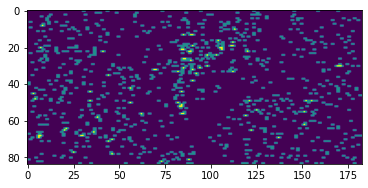

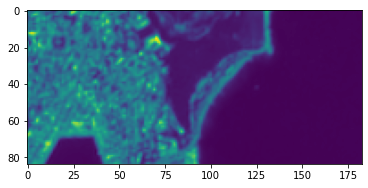

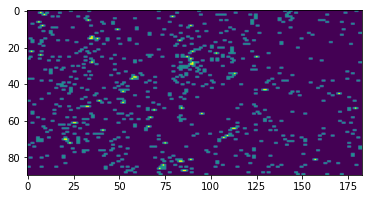

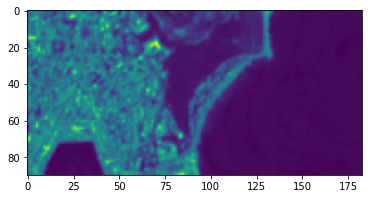

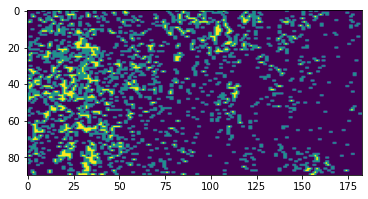

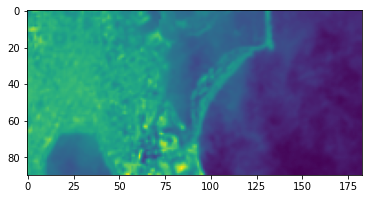

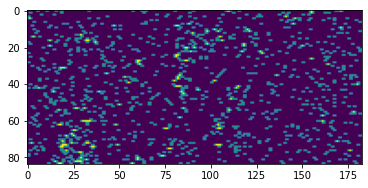

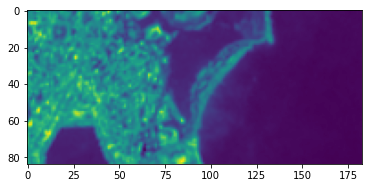

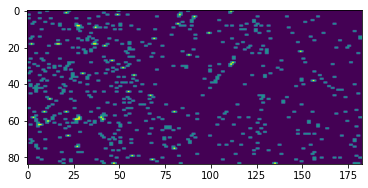

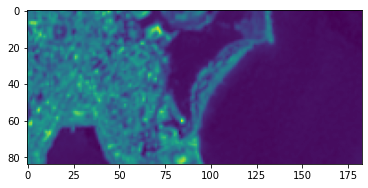

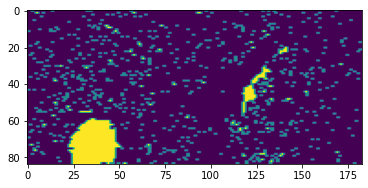

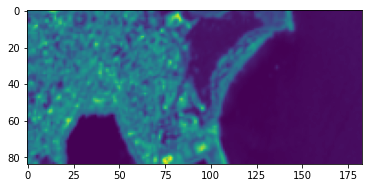

In [94]:
img_name = listdir(data_dir)
print(img_name)
seuil_test = 20
im_l=[]
lab_l=[]
for e in img_name:
    if e!='label' and e!='Mytilene':
        data_im, label_im = utils.get_batch(bands, e, all = False)
        im_l.append(data_im)
        lab_l.append(label_im)
        m,n = label_im.shape
        mu = np.mean(data_im[:,150:,2])
        x=np.array([d-mu for d in data_im[:,:,2].flatten()])
#         x=np.array(data_im[:,:,2].flatten())
        result_img = np.zeros(len(x))
        for k in range(len(x)-N):
            data = x[k:k+N]
         # estimated A
            A_est = np.mean([xi for xi in data])
#             A_list.append(A_est)
            # sigma 
            sigma2_0 = np.mean([(xi)**2 for xi in data])
            sigma2_1 = np.mean([(xi-A_est)**2 for xi in data])

            T = N*math.log(sigma2_0/sigma2_1)
            if T>seuil_test:
                result_img[k:k+N]+=1
                
        plt.figure()
        plt.imshow(result_img.reshape(m,n))

        plt.figure()
        plt.imshow(x.reshape(m,n))

ça ne fonctionne pas... Pistes d'amélioration : utiliser un kernel carré, essayer sur une bande plus discriminante (calculs mathématiques à faire ...), coupler les bandes.

## A ignorer, m'a servi pour faire ce que j'ai fait avant

In [38]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

# transorfm the dict into an array
def from_dict_to_array(img_bands):
    band_arrays = []
    for e in bands:
        band_arrays.append(img_bands[e])
    return band_arrays

def get_dataset(data_dir, bands):
    labels = []
    data = []
    img_name = listdir(data_dir)
    sizes= []
    for e in img_name : 
        if e!='label':
            data_im, label_im = utils.get_batch(bands, e, all = False)
            sizes.append(data_im.shape[0:2])
            flatten_labels = label_im.flatten()
            flatten_data = [data_im[:,:,i].flatten() for i in range(len(bands))]
            a_concat = np.zeros((flatten_data[0].shape[0],len(bands)))
            for i in range(0, len(flatten_data)):
                a_concat[:,i] = flatten_data[i]
            for k in range(flatten_data[0].shape[0]):
                data.append(a_concat[k])
            for e in flatten_labels:
                labels.append(e)

    return data, labels, sizes


In [52]:
## get images' directory

bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']


label_dir = './data/label/'
end = '_label.tif'
# img1 = '2019_04_18_M'
img1 = '2019_05_03_M'
img1_lab_path = label_dir + img1 + end
img1_lab = tifffile.imread(img1_lab_path)
print(img1_lab.shape)

img_bands = utils.get_band(bands,img1)
band_arrays = from_dict_to_array(img_bands)
print(band_arrays[0].shape)

table,lable = utils.get_batch(bands, img1, all = False)

(90, 183, 3)
(90, 183)


(90, 183)


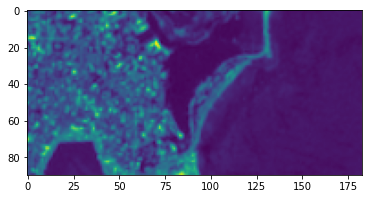

In [57]:
print(table[:,:,1].shape)
plt.imshow(table[:,:,1])

In [40]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
data, labels, sizes = get_dataset(data_dir, bands)

In [41]:
print(len(data))
L_data_band = [data[i][0] for i in range(len(data))]
print(len(L_data_band))

94428
94428


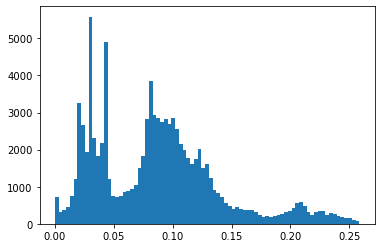

In [42]:
_ = plt.hist(L_data_band, bins='auto')

In [43]:
arrays = from_dict_to_array(img_bands)
m,n=arrays[0].shape
arrays_flat=np.array([e.flatten() for e in arrays])
X=(np.transpose(arrays_flat))
kmeans = KMeans(n_clusters=2,  init='k-means++', n_init=10, max_iter=1000)

kmeans.fit(X)


KMeans(max_iter=1000, n_clusters=2)

In [66]:
labels=kmeans.labels_
img_labels = labels.reshape(m,n)
clut = kmeans.cluster_centers_

In [112]:
spectral_sign = {'water' : clut[0], 'ground': clut[1]}
print(spectral_sign)

{'water': array([0.09084029, 0.10384066, 0.13632251, 0.16474463, 0.20498492,
       0.27273035, 0.29075953, 0.3045134 , 0.30009118, 0.29606405,
       0.28577173, 0.23582576], dtype=float32), 'ground': array([0.04694605, 0.03796409, 0.03244987, 0.02011696, 0.02140728,
       0.01972304, 0.02036767, 0.01891139, 0.02002294, 0.02978452,
       0.02321231, 0.02031878], dtype=float32)}


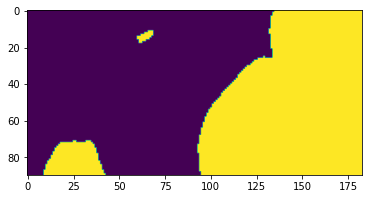

In [67]:
plt.figure()
plt.imshow(img_labels)

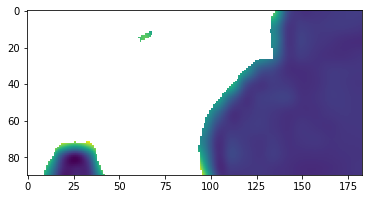

In [68]:
plt.imshow(arrays[0])

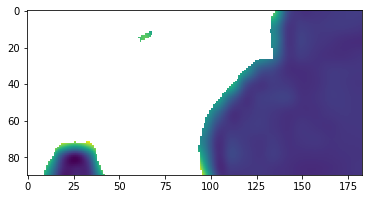

In [70]:
ori_array = arrays[0]
ori_array[img_labels == 0] = np.NaN
plt.imshow(ori_array)

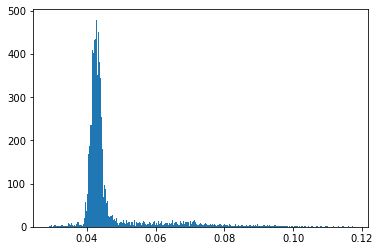

In [51]:
hist_0 = arrays[0].flatten()
_ = plt.hist(hist_0, bins='auto')